In [1]:
"""
EATING DISORDERS MONTECATINI

Purpose: pp check for HDDMrl model.

(1) diag_cat (diagnostic category) 

- AN     anorexia, 
- BN     bulimia, 
- HC     university students not at risk according to the EAT-26,
- RI     university students at risk according to the EAT-26, recovered bulimics, recovered anorexics.

(2) stim (stimulus)

- food and neutral images,
- two neutral images.

Some participants have been removed so as to avoind problems with the Gelman-Rubin index.
All excluded participants belong to the HC group, apart from al_ro_1989_04_25_160_f, who is AN.
There are 296 participants.

I removed 6 participants from the RI group:

to_be_deleted = [
"lu_mu_1997_03_18_059_f",
"de_sc_1992_07_02_116_f",
"fr_ro_1982_08_15_048_f",
"el_li_1999_09_08_687_f",
"ma_pi_2001_05_11_566_f",
"sa_sa_2000_11_24_418_m"
]

The purpose of this script is to test the PP Checks with a small number of participants in the HC group
who performed very well (high mean feedback scores).

Written by Corrado Caudek (2023-02-16)

"""


import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-02-16 22:01:15


In [1]:
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import arviz as az
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

ModuleNotFoundError: No module named 'hddm'

In [2]:
# load accuracy-coded data ('response' column represents accuracy: 1=correct trial; 0=error trial) 
data = hddm.load_csv(
    "/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/hddm_input_v20230216.csv"
)

to_be_deleted = [
    "lu_mu_1997_03_18_059_f",
    "de_sc_1992_07_02_116_f",
    "fr_ro_1982_08_15_048_f",
    "el_li_1999_09_08_687_f",
    "ma_pi_2001_05_11_566_f",
    "sa_sa_2000_11_24_418_m"
]

df = data.query("subj_code not in @to_be_deleted")
print("There are %d participants" % df["subj_idx"].nunique())

NameError: name 'hddm' is not defined

In [41]:
dicat_mapping = {
    "AN": "AN",
    "AN_R": "RI",
    "BN": "BN",
    "BN_R": "RI",
    "HC": "HC",
    "RI": "RI",
}
df = df.assign(diag_cat=df["diag_cat"].map(dicat_mapping))
df["diag_cat"].value_counts()

HC    62080
AN    11040
RI    10240
BN     3520
Name: diag_cat, dtype: int64

In [42]:
df["subj_idx"] = pd.factorize(df["subj_code"])[0] + 1
df["subj_idx"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [43]:
df.columns

Index(['subj_idx', 'response', 'stim', 'rt', 'trial', 'split_by', 'feedback',
       'diag_cat', 'subj_code', 'q_init'],
      dtype='object')

## Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approximated posterior distribution for all of the estimated group and subject parameters (column).

Let us consider only the AN patients in the food condition.

In [44]:
# bn_df = df.loc[(df["diag_cat"] == "BN") & (df["stim"] == "food")]
hc_df = df.loc[(df["diag_cat"] == "HC")]
hc_df.shape


(62080, 10)

In [ ]:
summary_stats = (
    hc_df.loc[:, ["subj_code", "stim", "feedback"]]
    .groupby(["subj_code"])
    .aggregate(["mean"])
)
# summary_stats.to_csv("fuck.csv")
print(summary_stats.to_string())

In [46]:
keep = [
    "al_ma_2001_03_01_678_f",
    "al_me_2001_06_24_456_f",
    "ar_in_1992_07_31_124_f",
    "ca_ma_2000_05_05_905_f",
    "ch_tr_2000_07_13_202_f",
    "em_se_2000_01_11_294_m",
    "so_sa_2001_06_25_188_f",
    "vi_ze_2001_01_02_521_f",
]

d = data.query("subj_code in @keep")
print("There are %d participants" % d["subj_idx"].nunique())

There are 8 participants


In [47]:
summary_stats = (
    d.loc[:, ["subj_code", "stim", "feedback"]]
    .groupby(["subj_code"])
    .aggregate(["count"])
)
# summary_stats.to_csv("fuck.csv")
print(summary_stats.to_string())

                        stim feedback
                       count    count
subj_code                            
al_ma_2001_03_01_678_f   320      320
al_me_2001_06_24_456_f   320      320
ar_in_1992_07_31_124_f   320      320
ca_ma_2000_05_05_905_f   320      320
ch_tr_2000_07_13_202_f   320      320
em_se_2000_01_11_294_m   320      320
so_sa_2001_06_25_188_f   320      320
vi_ze_2001_01_02_521_f   320      320


In [48]:
d.shape

(2560, 10)

In [49]:
d["subj_idx"] = pd.factorize(d["subj_code"])[0] + 1
d["subj_idx"].unique()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_7078/3651850969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["subj_idx"] = pd.factorize(d["subj_code"])[0] + 1


array([1, 2, 3, 4, 5, 6, 7, 8])

In [50]:
d.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
39520,1,0,food,0.613,1,0,0,HC,al_me_2001_06_24_456_f,0.5
39521,1,1,neutral,0.377,1,1,1,HC,al_me_2001_06_24_456_f,0.5
39522,1,1,food,0.575,2,0,1,HC,al_me_2001_06_24_456_f,0.5
39523,1,1,neutral,0.490,2,1,0,HC,al_me_2001_06_24_456_f,0.5
39524,1,1,food,0.328,3,0,1,HC,al_me_2001_06_24_456_f,0.5


In [51]:
m = hddm.HDDMrl(
    d,
    # bias=True,
    depends_on={
        "a": ["stim"],
        "v": ["stim"],
        "t": ["stim"],
        "alpha": ["stim"],
        "pos_alpha": ["stim"],
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True,  # informative priors on ddm params
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [52]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        data=d,
        depends_on={
            "a": ["stim"],
            "v": ["stim"],
            "t": ["stim"],
            "alpha": ["stim"],
            "pos_alpha": ["stim"],
        },
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True,
    )
    m.sample(500, burn=200, dbname="traces.db", db="pickle")
    models.append(m)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 500 of 500 complete in 26.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 500 of 500 complete in 26.6 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 500 of 500 complete in 26.5 sec

In [53]:
m = kabuki.utils.concat_models(models)

In [54]:
m.print_stats()

                               mean       std      2.5q       25q       50q       75q      97.5q    mc err
a(food)                    1.393025  0.083231   1.23127  1.335035  1.390742  1.446324    1.55709  0.002851
a(neutral)                 1.266351  0.084969  1.105119  1.211019  1.265402  1.320314   1.448389  0.003515
a_std                      0.232687  0.051649  0.152604  0.197331  0.224362  0.259565   0.357684  0.002541
a_subj(food).1             1.009534  0.041117  0.932624  0.980518  1.009749  1.037145   1.091514  0.001836
a_subj(food).2             1.472525  0.060086  1.366745  1.429776  1.470028  1.514833   1.595489  0.003086
a_subj(food).3             1.295956  0.049171  1.204638  1.261935  1.295082  1.324753    1.39511  0.002255
a_subj(food).4             1.395901  0.063542  1.284454  1.348765  1.393636  1.435206   1.535328  0.003327
a_subj(food).5             1.449636  0.060576  1.343279   1.40697  1.449432  1.491438   1.580083  0.002927
a_subj(food).6             1.444724  

In [55]:
traces = m.get_traces()
traces.head()

,a(food),a(neutral),a_std,a_subj(food).1,a_subj(food).2,a_subj(food).3,a_subj(food).4,a_subj(food).5,a_subj(food).6,a_subj(food).7,...,pos_alpha_subj(food).7,pos_alpha_subj(food).8,pos_alpha_subj(neutral).1,pos_alpha_subj(neutral).2,pos_alpha_subj(neutral).3,pos_alpha_subj(neutral).4,pos_alpha_subj(neutral).5,pos_alpha_subj(neutral).6,pos_alpha_subj(neutral).7,pos_alpha_subj(neutral).8
0,1.231761,1.385178,0.237406,0.963253,1.585964,1.278196,1.299891,1.399242,1.484388,1.652526,...,5.738788,5.734108,2.996468,-2.066188,2.760453,7.776540,-0.566911,0.206323,0.261655,4.066570
1,1.543745,1.342208,0.271736,1.049360,1.552631,1.393535,1.287268,1.396036,1.564587,1.644516,...,4.457195,8.509571,3.364352,-2.563771,5.474118,4.182940,5.979860,0.037018,0.287271,2.035793
2,1.262554,1.269041,0.229254,1.032018,1.558023,1.296496,1.485893,1.440095,1.572848,1.603924,...,3.955522,9.536140,3.023436,-2.513757,5.160477,2.086607,5.389397,0.199882,0.118673,-0.554644
3,1.228825,1.246008,0.219842,1.052017,1.482506,1.297261,1.425282,1.331260,1.470732,1.588669,...,3.978674,8.585993,5.989592,-2.478057,1.953826,3.045164,2.120255,0.268656,1.231662,3.144180
4,1.493490,1.206271,0.245415,0.927315,1.509955,1.272945,1.434702,1.484920,1.430038,1.687149,...,2.214775,5.564616,2.748421,-1.767545,5.946887,4.004196,0.379058,0.067102,-0.867869,6.159897


In [56]:
data = d

In [57]:
from tqdm import tqdm  # progress tracker

# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
data["samp"] = 0
# load traces
traces = m.get_traces()
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 11)): ## it was 51
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0] - 1)
    # loop through all subjects in observed data
    for s in data.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 0)].trial.unique()
        )
        size1 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 1)].trial.unique()
        )
        # set parameter values for simulation
        a_n = traces.loc[sample, "a_subj(neutral)." + str(s)]
        t_n = traces.loc[sample, "t_subj(neutral)." + str(s)]
        scaler_n = traces.loc[sample, "v_subj(neutral)." + str(s)]
        alphaInv_n = traces.loc[sample, "alpha_subj(neutral)." + str(s)]
        alpha_n = np.exp(alphaInv_n) / (1 + np.exp(alphaInv_n))
        posAlphaInv_n = traces.loc[sample, "pos_alpha_subj(neutral)." + str(s)]
        pos_alpha_n = np.exp(posAlphaInv_n) / (1 + np.exp(posAlphaInv_n))
        
        a_f = traces.loc[sample, "a_subj(food)." + str(s)]
        t_f = traces.loc[sample, "t_subj(food)." + str(s)]
        scaler_f = traces.loc[sample, "v_subj(food)." + str(s)]
        alphaInv_f = traces.loc[sample, "alpha_subj(food)." + str(s)]
        alpha_f = np.exp(alphaInv_f) / (1 + np.exp(alphaInv_f))
        posAlphaInv_f = traces.loc[sample, "pos_alpha_subj(food)." + str(s)]
        pos_alpha_f = np.exp(posAlphaInv_f) / (1 + np.exp(posAlphaInv_f))
        
        # simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a_n,
            t=t_n,
            scaler=scaler_n,
            alpha=alpha_n,
            pos_alpha=pos_alpha_n,
            size=size0,
            p_upper=0.7,
            p_lower=0.3,
            split_by=0,
        )
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a_f,
            t=t_f,
            scaler=scaler_f,
            alpha=alpha_f,
            pos_alpha=pos_alpha_f,
            size=size1,
            p_upper=0.7,
            p_lower=0.3,
            split_by=1,
        )
        # append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # assign subj_idx
        sim_data0["subj_idx"] = s
        # identify that these are simulated data
        sim_data0["type"] = "simulated"
        # identify the simulated data
        sim_data0["samp"] = i
        # append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)
# combine observed and simulated data
ppc_data = data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "samp"]
].copy()
ppc_data["type"] = "observed"
ppc_sdata = sim_data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "type", "samp"]
].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv("ppc_data_tutorial.csv")

100%|██████████| 10/10 [01:52<00:00, 11.24s/it]


In [64]:
plot_ppc_data = ppc_data[(ppc_data.trial > 60) & (ppc_data.trial < 81)].copy()
plot_ppc_data = ppc_data

In [65]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data["bin_trial"] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)
).astype("int64")
# calculate means for each sample
sums = (
    plot_ppc_data.groupby(["bin_trial", "split_by", "samp", "type"])
    .mean()
    .reset_index()
)
# calculate the overall mean response across samples
ppc_sim = sums.groupby(["bin_trial", "split_by", "type"]).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim["upper_hpd"] = 0
ppc_sim["lower_hpd"] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(
        sums.response[
            (sums["bin_trial"] == ppc_sim.bin_trial[i])
            & (sums["split_by"] == ppc_sim.split_by[i])
            & (sums["type"] == ppc_sim.type[i])
        ],
        alpha=0.1,
    )
    ppc_sim.loc[i, "upper_hpd"] = hdi[1]
    ppc_sim.loc[i, "lower_hpd"] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim["up_err"] = ppc_sim["upper_hpd"] - ppc_sim["response"]
ppc_sim["low_err"] = ppc_sim["response"] - ppc_sim["lower_hpd"]
ppc_sim["model"] = "RLDDM_single_learning"
ppc_sim.to_csv("ppc_choicedata_tutorial.csv")

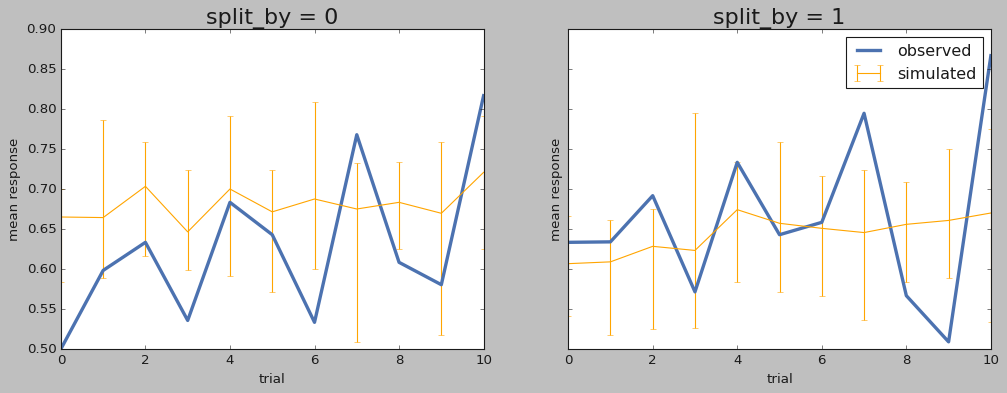

In [66]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "simulated")]
    ax.errorbar(
        d.bin_trial,
        d.response,
        yerr=[d.low_err, d.up_err],
        label="simulated",
        color="orange",
    )
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "observed")]
    ax.plot(d.bin_trial, d.response, linewidth=3, label="observed")
    ax.set_title("split_by = %i" % i, fontsize=20)
    ax.set_ylabel("mean response")
    ax.set_xlabel("trial")
plt.legend()
fig.savefig("PPCchoice.pdf")